### Analyze the DG535 double pulse data acquired on Nov. 18, 2020 with the WDC v1 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.colors as mplcolors
from matplotlib import pyplot as plt

from common import *

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

clock_freq = 245.76  # MHz
template_splines = np.load('dg535_wdcv1_splines_11_18_2020.npy', allow_pickle=True)
with np.load('cfd_cor_250_d1_s1_500_d2_s1.npz', allow_pickle=True) as npf:
    cfd_cor_splines = npf['a']
    cfd_cor_zeros = npf['b']
    
cfd_cors = list(zip(cfd_cor_splines, cfd_cor_zeros))
cfd_pars = [(1,1), (1, 1), (2, 1)]

In [3]:
double_pulse_wfms = load_data('double_pulse_11_18_2020-18_56_50.npz')

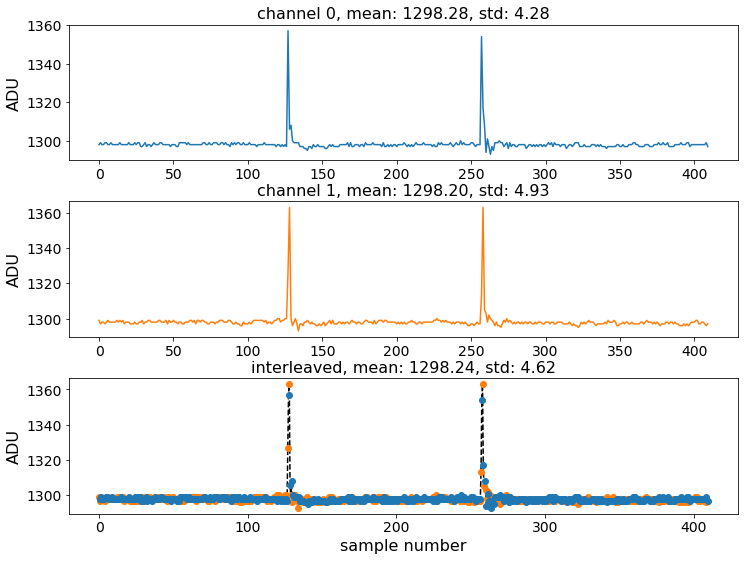

In [4]:
plot_wfms(double_pulse_wfms[1])

### The pulses are far enough apart that I will fit them separately. For each waveform, I will apply a CFD and a template fit to each pulse.

In [5]:
def fit_double_pulse(wfm, templ, cfd_pars, cfd_cor, split_ind=180, second_templ=None, second_cfd_cor=None):
    samples = wfm['samples']
    
    first_pulse = samples[:split_ind]
    second_pulse = samples[split_ind:]
    
    results = []
    for i, pulse in enumerate([first_pulse, second_pulse]):
        if i == 1 and second_templ is not None:
            pulse_template = second_templ
        else:
            pulse_template = templ
        
        if i == 1 and second_cfd_cor is not None:
            phase_cor = second_cfd_cor
        else:
            phase_cor = cfd_cor
        
        tf_res = template_fit(pulse, pulse_template, n_baseline=50)[0]
        cfd_res = cfd(pulse, *cfd_pars, n_baseline=50)[-1]
        cor_cfd_res = apply_phase_correction(cfd_res, *phase_cor)
        
        if i == 1:
            tf_res[0][1] += split_ind
            cfd_res += split_ind
            cor_cfd_res += split_ind
        
        results.append((tf_res, cfd_res, cor_cfd_res))
        
    return results


def plot_double_pulse_fit(wfm, templ, cfd_pars, cfd_cor, split_ind=180, 
                          second_templ=None,second_cfd_cor=None):
    fit_res = fit_double_pulse(wfm, templ, cfd_pars, cfd_cor, split_ind, second_templ, second_cfd_cor)
        
    samples = [wfm['samples'][:split_ind], wfm['samples'][split_ind:]]
    sample_nums = [np.arange(0, split_ind), np.arange(split_ind, len(wfm['samples']))]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)
    for t, samps, res, ax in zip(sample_nums, samples, fit_res, axes.flat):
        if t[0] != 0 and second_templ is not None:
            pulse_template = second_templ
        else:
            pulse_template = templ
        
        i_max = np.argmax(samps)
        t_max = t[i_max]
        t_pts = np.linspace(t_max - 5, t_max + 5, 1000)
                            
        ax.plot(t, samps, 'o', color=colors[0], label='samples')
        ax.plot(t_pts, get_template_fit_func(pulse_template)(t_pts, *res[0][0]), 
                '--', color=colors[0], label='template fit')
        ax.axvline(res[-1], linestyle='--', color=colors[1], label='CFD')
        
        ax.set_xlim(t_max - 6, t_max + 6)
        ax.set_xlabel('time (sample num)')
        ax.set_ylabel('ADU')
        ax.legend(bbox_to_anchor=(1.1, 1))
        
    return fig

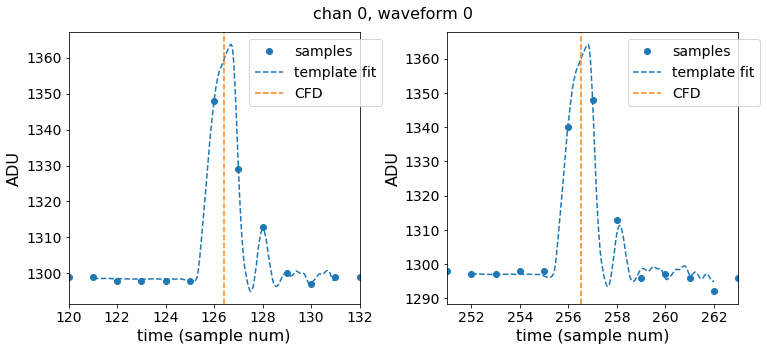

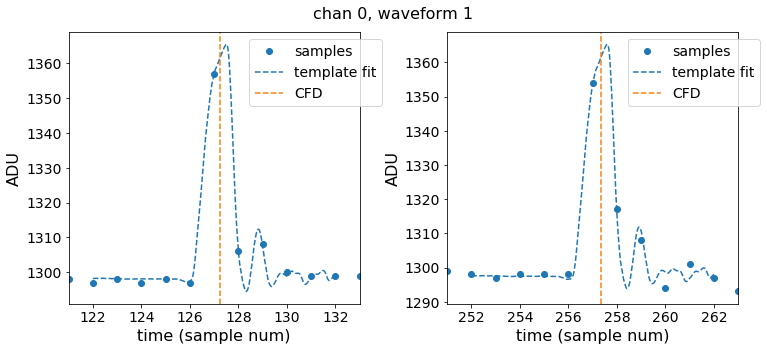

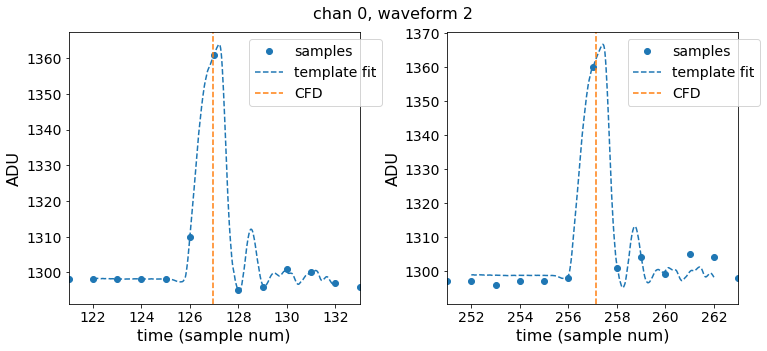

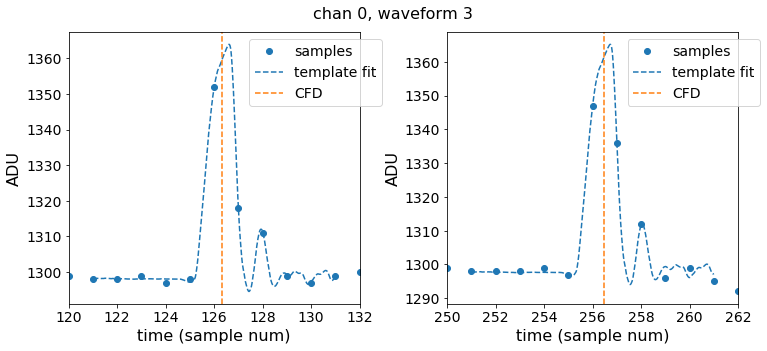

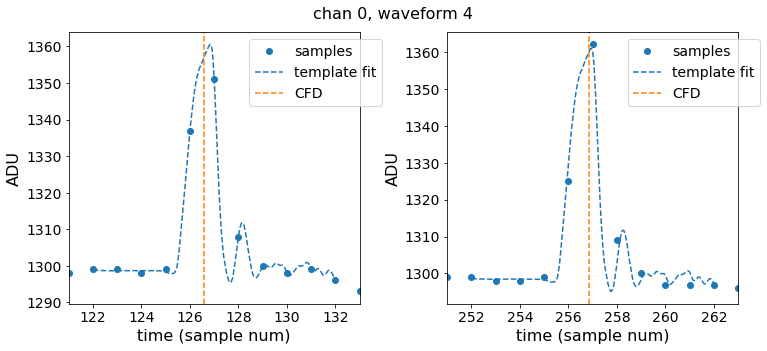

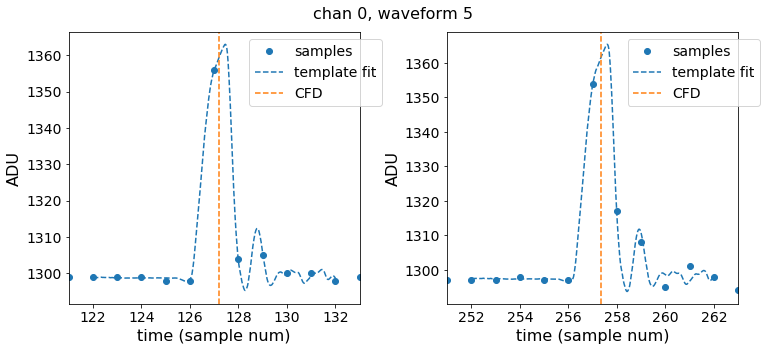

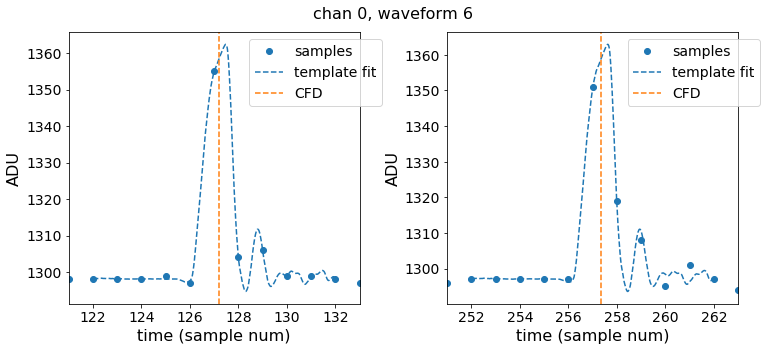

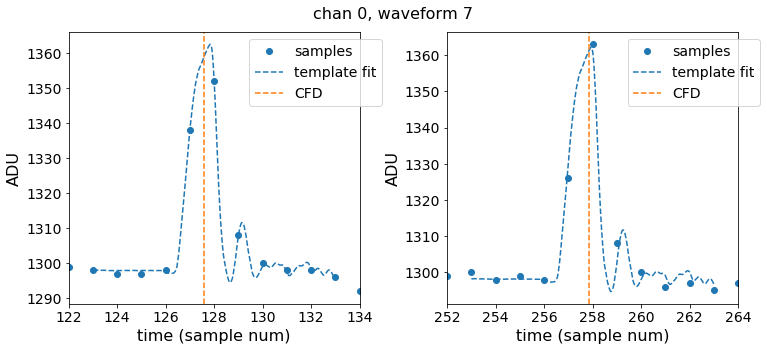

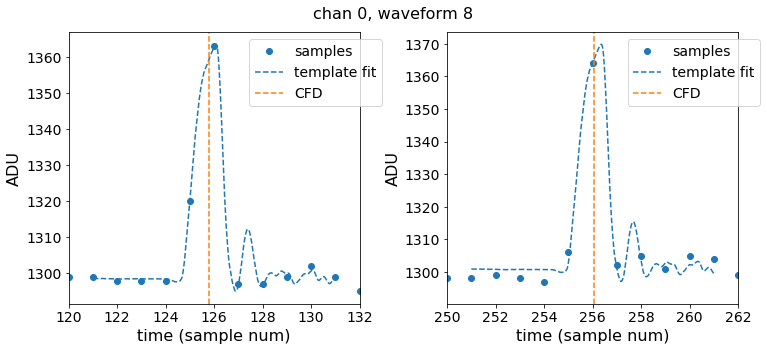

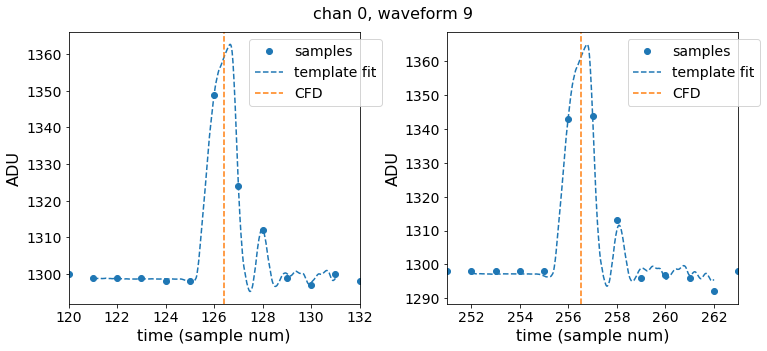

In [6]:
for i in range(10):
    fig = plot_double_pulse_fit(double_pulse_wfms[i][0], template_splines[0], cfd_pars[0], cfd_cors[0])
    fig.suptitle(f'chan 0, waveform {i}', y=0.95, fontsize=16)

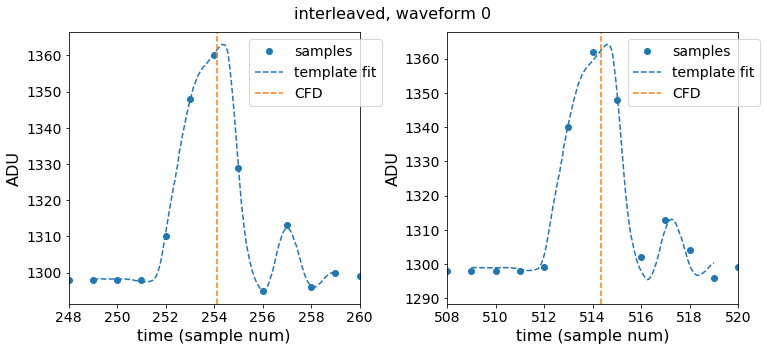

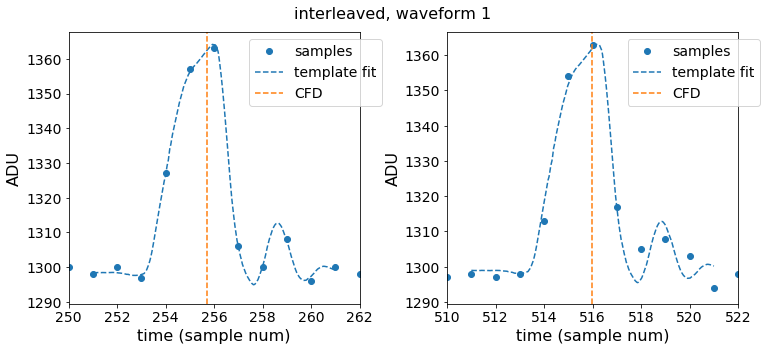

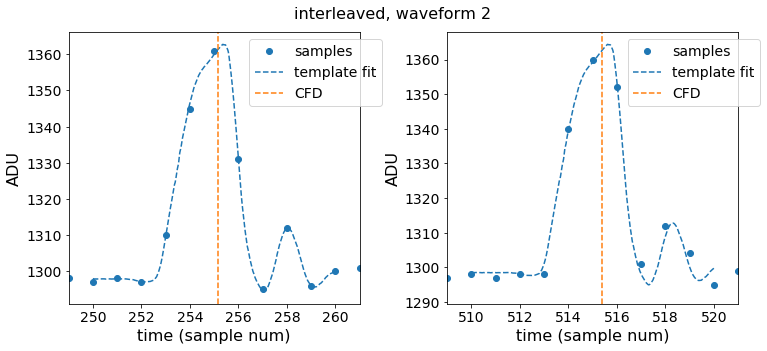

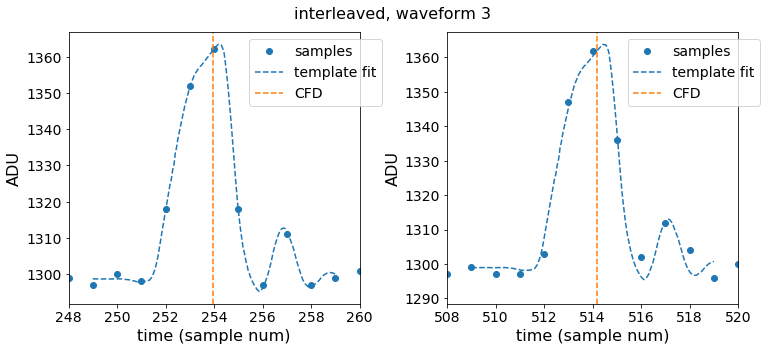

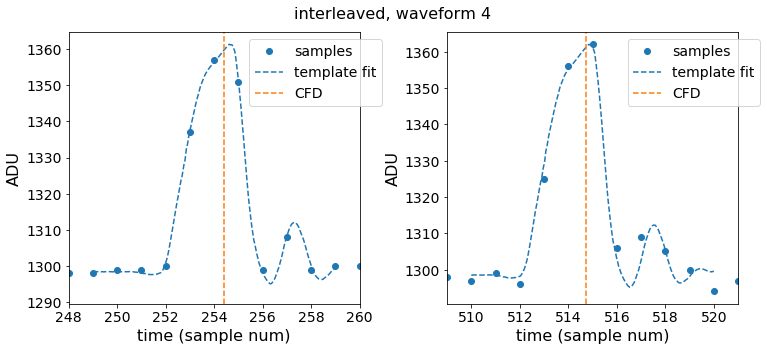

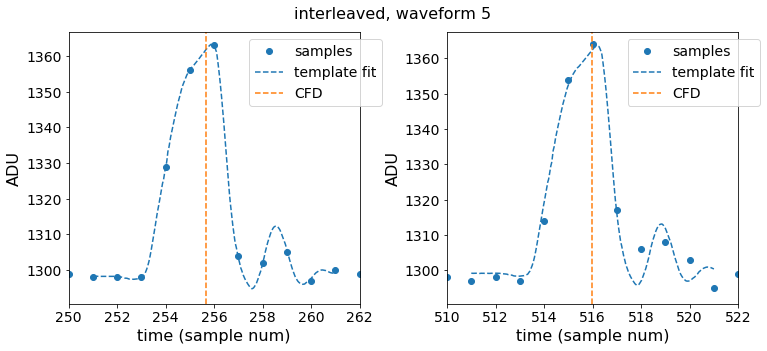

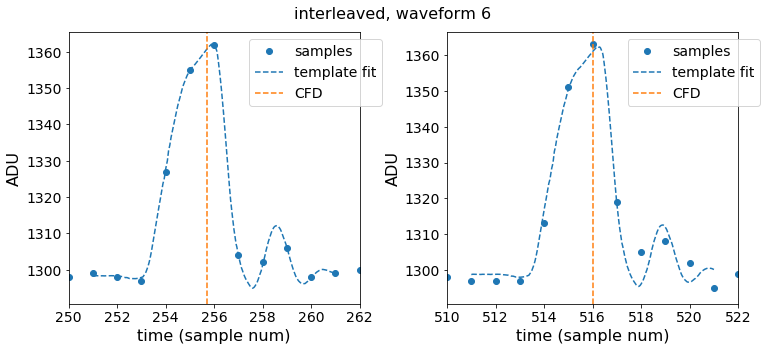

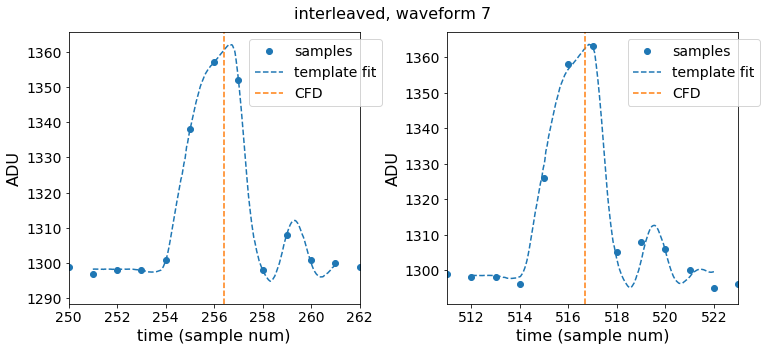

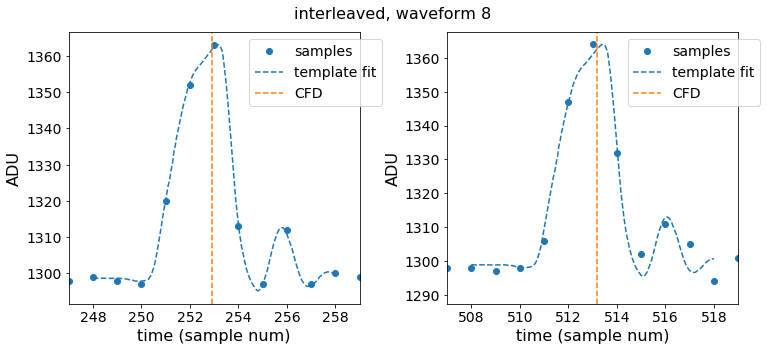

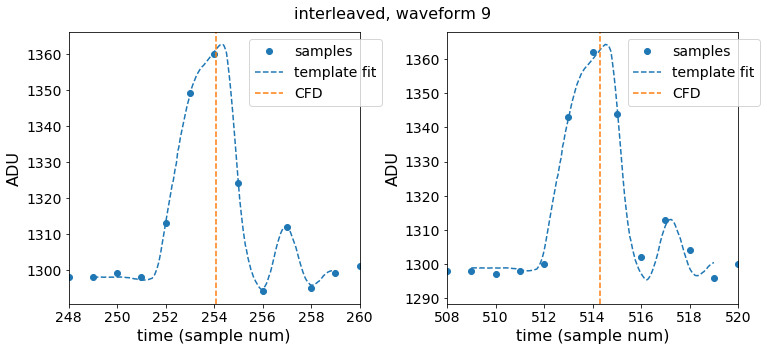

In [7]:
for i in range(10):
    wfm = build_combined_wfm(double_pulse_wfms[i])
    fig = plot_double_pulse_fit(wfm, template_splines[2], cfd_pars[2], cfd_cors[2], split_ind=360)
    fig.suptitle(f'interleaved, waveform {i}', y=0.95, fontsize=16)

In [8]:
%%time

fit_results = []
for event in double_pulse_wfms:
    event_res = []
    
    for wfm, templ, cfd_par, cfd_cor in zip(event, template_splines, cfd_pars, cfd_cors):
        event_res.append(fit_double_pulse(wfm, templ, cfd_par, cfd_cor))
        
    combined_wfm = build_combined_wfm(event)
    event_res.append(fit_double_pulse(combined_wfm, template_splines[-1], cfd_pars[-1], 
                                      cfd_cors[-1], split_ind=360))
    
    fit_results.append(event_res)

CPU times: user 46.6 s, sys: 15.6 ms, total: 46.6 s
Wall time: 46.7 s


### Look at pulse-pulse time difference within a channel

In [9]:
chan_diffs = []
for chan in range(3):
    tf_diffs = np.array([e[chan][1][0][0][1] - e[chan][0][0][0][1] for e in fit_results])
    cfd_diffs = np.array([e[chan][1][1] - e[chan][0][1] for e in fit_results])
    cor_cfd_diffs = np.array([e[chan][1][2] - e[chan][0][2] for e in fit_results])
    
    chan_diffs.append((tf_diffs, cfd_diffs, cor_cfd_diffs))

### Some events appear to have anomalous time differences. What's causing it?

In [10]:
np.argwhere(chan_diffs[0][0] <100)

array([[4643],
       [4648],
       [7123]])

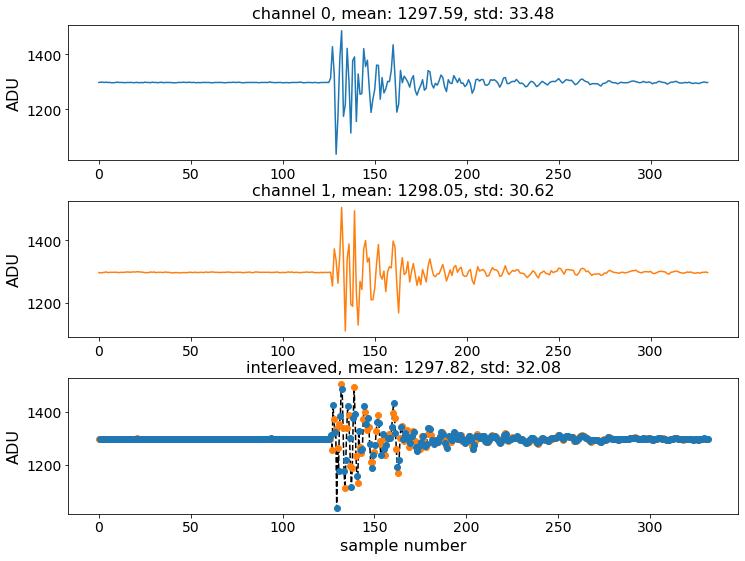

In [11]:
plot_wfms(double_pulse_wfms[4643])

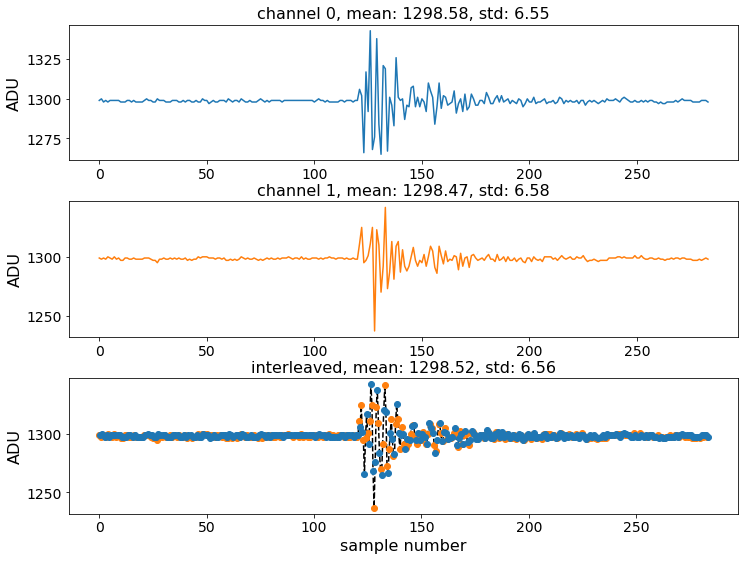

In [12]:
plot_wfms(double_pulse_wfms[4648])

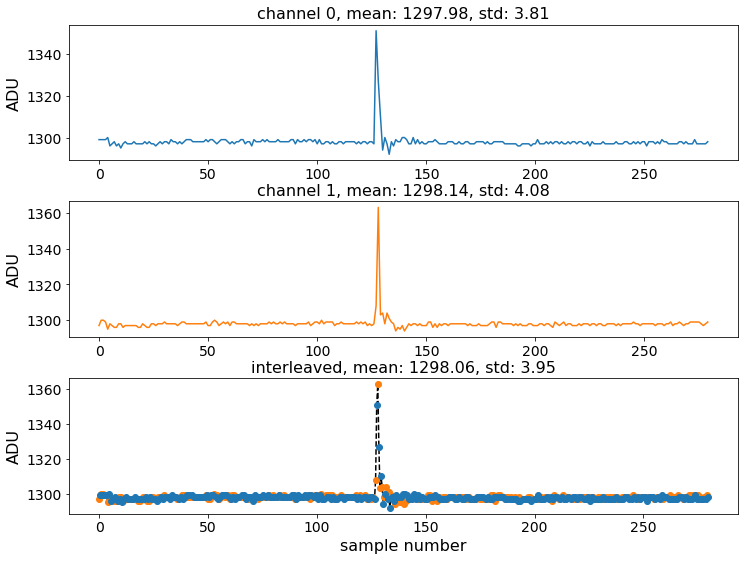

In [13]:
plot_wfms(double_pulse_wfms[7123])

### There is at least one event triggering on the second pulse, and there are a couple noisy looking waveforms. I should be able to cut these out based on the waveform length.

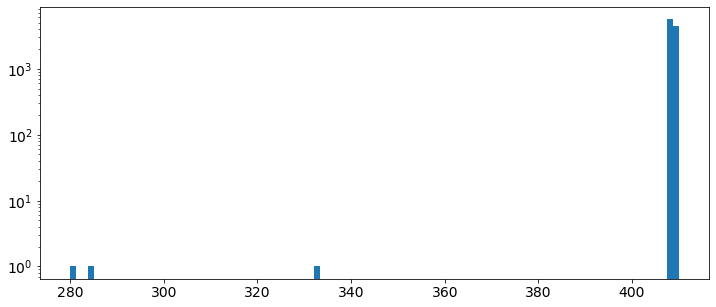

In [14]:
wfm_lens = np.array([len(e[0]['samples']) for e in double_pulse_wfms])
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(wfm_lens, bins=100)
ax.set_yscale('log')

In [15]:
good_inds = wfm_lens > 400

In [16]:
def double_pulse_plot(chan, chan_diffs, ax, skip_noncor=False, bin_range=(-1, 1), good_inds=good_inds):
    tf_diff, cfd_diff, cor_cfd_diff = chan_diffs[chan]
    
    sample_freq = clock_freq if chan != 2 else 2 * clock_freq
    
    bins = np.linspace(*bin_range, 250)
    for label, diff in zip(['template fit', 'corrected cfd', 'cfd'],
                           [tf_diff, cor_cfd_diff, cfd_diff]):
        if label == 'cfd' and skip_noncor:
            continue
        diff = diff[good_inds] * 1e3 / sample_freq
        std = diff.std()
        label += f', $\sigma$: {std*1000:.0f} ps'
        hist, _ = np.histogram((diff - diff.mean()), bins)
#         hist_bins = bins + diff.mean()
#         hist, _ = np.histogram(diff, hist_bins)
        ax.step(bins[:-1], hist, where='post', label=label)
                
    if chan == 0:
        ax.set_title('250 MSPS Ch. 0')
    elif chan == 1:
        ax.set_title('250 MSPS Ch. 1')
    elif chan == 2:
        ax.set_title('500 MSPS (interleaved)')
        ax.set_xlabel(r'$\Delta t - \langle \Delta t \rangle $ (ns)')
    
    ax.set_ylabel('n waveforms')
    ax.legend()

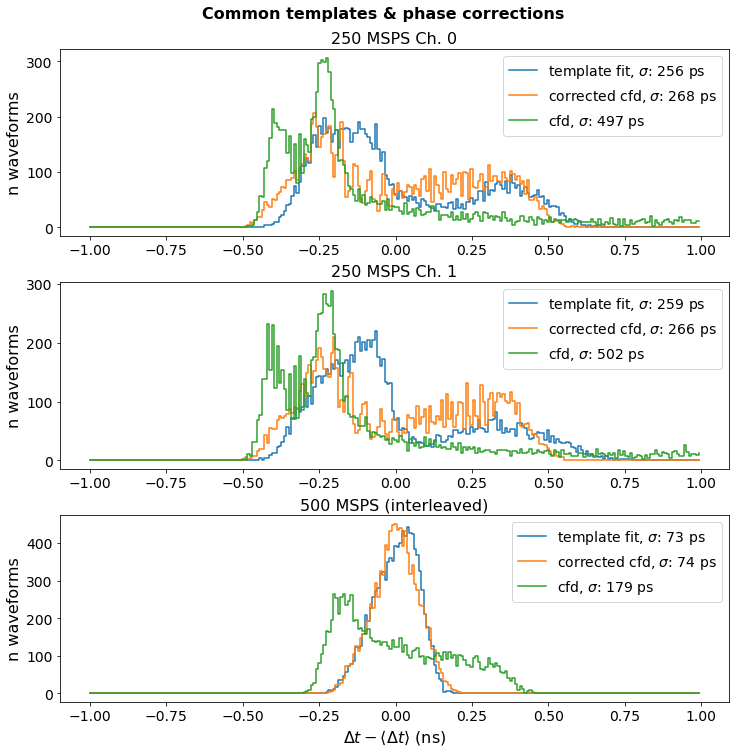

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.25)
for i, ax in enumerate(axes.flat):
    double_pulse_plot(i, chan_diffs, ax)
    
fig.suptitle('Common templates & phase corrections', fontsize=16, y=0.93, fontweight='bold')
fig.savefig('double_pulse_common.png', bbox='tight')

In [18]:
0.4*clock_freq/1000.0

0.098304

In [19]:
mean_cor_diffs = chan_diffs[0][0] - chan_diffs[0][0][good_inds].mean()

In [20]:
np.argwhere(mean_cor_diffs[good_inds] > 0.1)[1]

array([50])

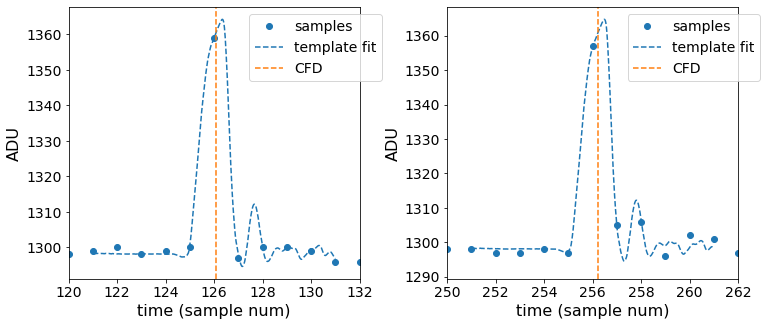

In [21]:
fig = plot_double_pulse_fit(double_pulse_wfms[49][0], template_splines[0], cfd_pars[0], cfd_cors[0])

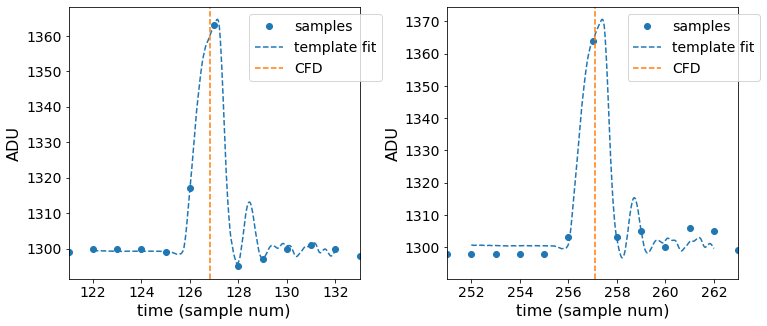

In [22]:
fig = plot_double_pulse_fit(double_pulse_wfms[50][0], template_splines[0], cfd_pars[0], cfd_cors[0])
fig.savefig('fit_wrong_templates.png', bbox='tight')

### I need to build a separate template for the second pulse in order for this to work at 250 MSPS. I'll try that out...

In [23]:
second_template_splines = np.load('dg535_wdcv1_splines_second_pulse_11_18_2020.npy', allow_pickle=True)
with np.load('cfd_cor_250_d1_s1_500_d2_s1_second_pulse.npz', allow_pickle=True) as npf:
    second_cfd_cor_splines = npf['a']
    second_cfd_cor_zeros = npf['b']
second_cfd_cors = list(zip(second_cfd_cor_splines, second_cfd_cor_zeros))

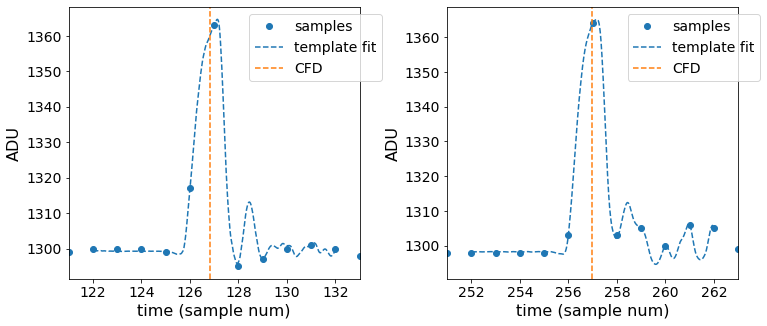

In [24]:
fig = plot_double_pulse_fit(double_pulse_wfms[50][0], template_splines[0], cfd_pars[0], cfd_cors[0], 
                            second_templ=second_template_splines[0], second_cfd_cor=second_cfd_cors[0])
fig.savefig('fit_right_templates.png', bbox='tight')

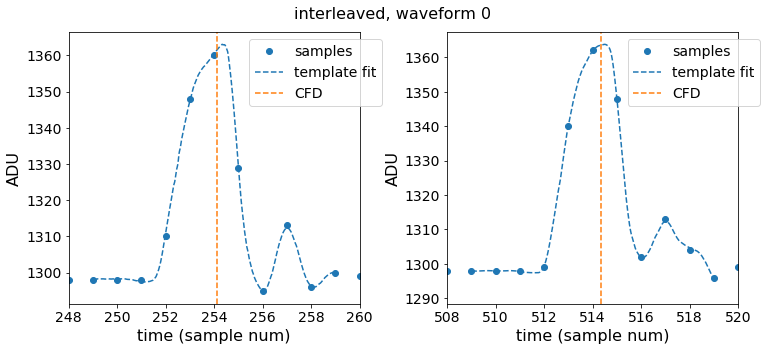

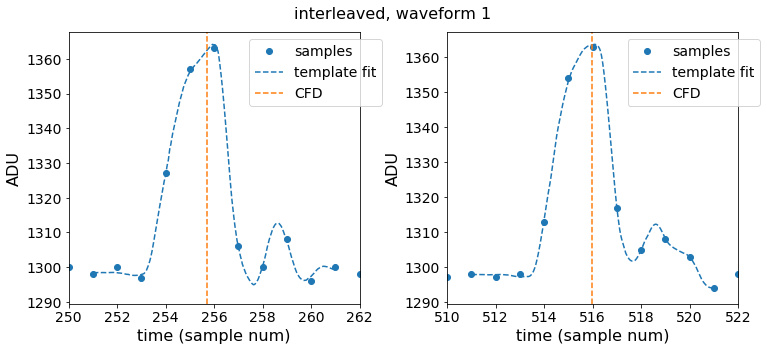

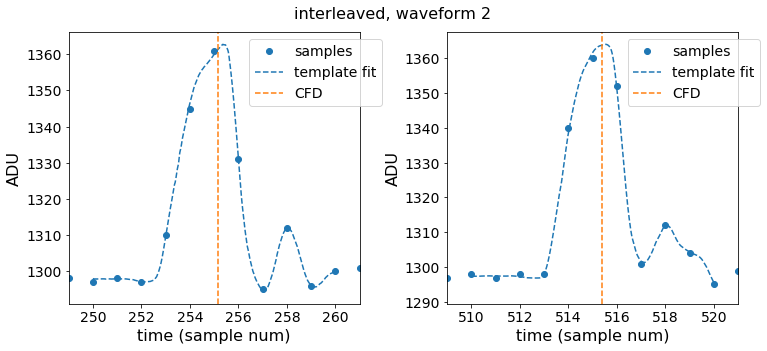

In [25]:
for i in range(3):
    wfm = build_combined_wfm(double_pulse_wfms[i])
    fig = plot_double_pulse_fit(wfm, template_splines[2], cfd_pars[2], cfd_cors[2], split_ind=360, second_templ=second_template_splines[2])
    fig.suptitle(f'interleaved, waveform {i}', y=0.95, fontsize=16)

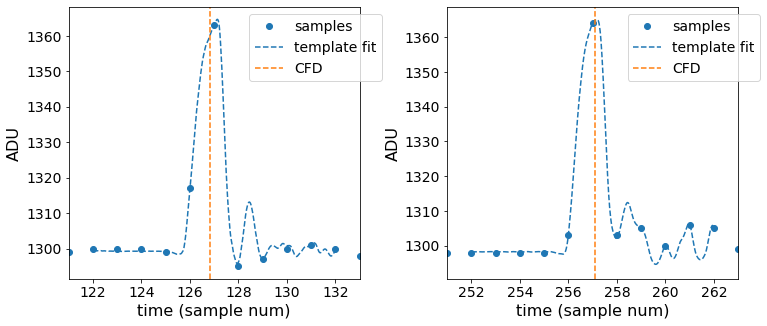

In [26]:
fig = plot_double_pulse_fit(double_pulse_wfms[50][0], template_splines[0], cfd_pars[0], cfd_cors[0], second_templ=second_template_splines[0])

### Clearly makes a big difference... let's redo the above timing analysis

In [27]:
%%time

fit_results = []
for event in double_pulse_wfms:
    event_res = []
    
    for wfm, templ, second_templ, cfd_par, cfd_cor, second_cor in zip(event, template_splines, 
                                                                      second_template_splines, cfd_pars, 
                                                                      cfd_cors, second_cfd_cors):
        event_res.append(fit_double_pulse(wfm, templ, cfd_par, cfd_cor, 
                                          second_templ=second_templ, second_cfd_cor=second_cor))
        
    combined_wfm = build_combined_wfm(event)
    event_res.append(fit_double_pulse(combined_wfm, template_splines[-1], cfd_pars[-1], 
                                      cfd_cors[-1], split_ind=360, 
                                      second_templ=second_template_splines[-1],
                                      second_cfd_cor=second_cfd_cors[-1]))
    
    fit_results.append(event_res)

CPU times: user 40.9 s, sys: 0 ns, total: 40.9 s
Wall time: 40.9 s


In [28]:
chan_diffs = []
for chan in range(3):
    tf_diffs = np.array([e[chan][1][0][0][1] - e[chan][0][0][0][1] for e in fit_results])
    cfd_diffs = np.array([e[chan][1][1] - e[chan][0][1] for e in fit_results])
    cor_cfd_diffs = np.array([e[chan][1][2] - e[chan][0][2] for e in fit_results])
    
    chan_diffs.append((tf_diffs, cfd_diffs, cor_cfd_diffs))

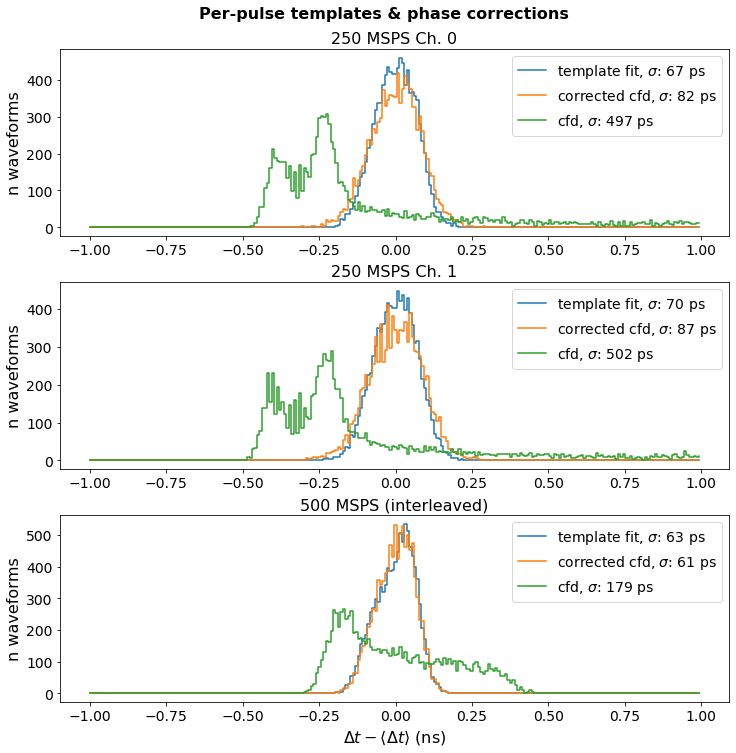

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.25)
for i, ax in enumerate(axes.flat):
    double_pulse_plot(i, chan_diffs, ax)
    
fig.suptitle('Per-pulse templates & phase corrections', fontsize=16, y=0.93, fontweight='bold')
fig.savefig('double_pulse_tuned.png', bbox='tight')